In [1]:
import os
import random
from shutil import copyfile
import numpy as np
from sklearn.metrics import *
!pip install --upgrade keras

Requirement already up-to-date: keras in /opt/conda/lib/python3.7/site-packages (2.4.3)


In [2]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import Dense,Activation
from keras import models
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.applications import inception_v3

# Splitting Images between Multiple Folders:

Certain Parts referenced from:

https://gist.github.com/bertcarremans/679624f369ed9270472e37f8333244f5

In [3]:
def img_train_test_split(img_source_dir, train_size, validation_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """
        
    # Set up empty folder structure if not exists
    if not os.path.exists('data'):
        os.makedirs('data')
    else:
        if not os.path.exists('data/train'):
            os.makedirs('data/train')
        if not os.path.exists('data/validation'):
            os.makedirs('data/validation')
        if not os.path.exists('data/test'):
            os.makedirs('data/test')    
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('data/train', subdir)
        validation_subdir = os.path.join('data/validation', subdir)
        test_subdir = os.path.join('data/test', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)
            
        if not os.path.exists(test_subdir):
            os.makedirs(test_subdir)

        train_counter = 0
        validation_counter = 0
        test_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    if random.uniform(0, 1) <= validation_size:
                        copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                        validation_counter += 1
                    else:
                        copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                        train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(test_subdir, str(test_counter) + '.' + fileparts[1]))
                    test_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to data/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to data/validation/' + subdir)
        print('Copied ' + str(test_counter) + ' images to data/test/' + subdir)

In [4]:
!mkdir /tmp/Xray_train_data
!cp -R "../input/covid19-radiography-database/COVID-19 Radiography Database/Viral Pneumonia" "/tmp/Xray_train_data/Viral Pneumonia"
!cp -R "../input/covid19-radiography-database/COVID-19 Radiography Database/NORMAL" "/tmp/Xray_train_data"
!cp -R "../input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19" "/tmp/Xray_train_data"
!ls "/tmp/Xray_train_data/"

 COVID-19   NORMAL  'Viral Pneumonia'


In [5]:
train_data_dir= "/tmp/Xray_train_data"

In [6]:
img_train_test_split(train_data_dir, 0.8, 0.2)

Copied 147 images to data/train/COVID-19
Copied 31 images to data/validation/COVID-19
Copied 41 images to data/test/COVID-19
Copied 856 images to data/train/NORMAL
Copied 207 images to data/validation/NORMAL
Copied 278 images to data/test/NORMAL
Copied 868 images to data/train/Viral Pneumonia
Copied 238 images to data/validation/Viral Pneumonia
Copied 239 images to data/test/Viral Pneumonia


In [7]:
COUNT_NORMAL = len([filename for filename in os.listdir('data/train/NORMAL')])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_COVID = len([filename for filename in os.listdir('data/train/COVID-19')])
print("COVID-19 images count in training set: " + str(COUNT_COVID))

COUNT_PNEUMONIA = len([filename for filename in os.listdir('data/train/Viral Pneumonia')])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print("Normal images count in training set: " + str(COUNT_NORMAL + COUNT_COVID + COUNT_PNEUMONIA))

Normal images count in training set: 856
COVID-19 images count in training set: 147
Pneumonia images count in training set: 868
Normal images count in training set: 1871


In [8]:
# plt.figure(figsize=(10,5))
# plt.plot(history.history["recall"],label="recall")
# plt.plot(history.history["val_recall"],label="val_recall")
# plt.legend(loc='upper left')

In [9]:
def Complete_data_generator(img_height = 1024, img_width=1024, batch_size = 16, split = 0.3):

    training_data_directory = "data/train"
    validation_data_directory = "data/validation"
    test_data_directory = "data/test"
    
    
    # Rotation is not helpful since, all images have a normalized orientation [Pretty much standard for any xray]
    # Vertical Flip is also not useful for same reasons
    # I beleive horizontal flip to be important due to the possibility of more evident infection in one lung.
    
    
    train_datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./255, featurewise_center=True,
                     featurewise_std_normalization=True)
    test_datagen = ImageDataGenerator(horizontal_flip=True, rescale=1./255, featurewise_center=True,
                     featurewise_std_normalization=True)

    train_generator = train_datagen.flow_from_directory(
        training_data_directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_generator = test_datagen.flow_from_directory(
        validation_data_directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_data_directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    return train_generator, validation_generator, test_generator

In [10]:
METRICS = [
        'accuracy',
        keras.metrics.Recall(name="recall")
]

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import keras
from keras.models import load_model

In [12]:
pretrained_model = load_model('../input/pneumatic-vs-normal-pretrained-model/PneumoniaVNormal.h5')

print('Model Loaded')

pretrained_model.pop()

pretrained_model.add(Dense(3, activation = "softmax", name = "classification_layer"))

Model Loaded


In [13]:
pretrained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1

In [14]:
pretrained_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics = METRICS)

train_generator, validation_generator, test_generator = Complete_data_generator(224, 224)

trainer = pretrained_model.fit(train_generator,validation_data=validation_generator,epochs=20,verbose=2)

pretrained_model.save('Final.h5', overwrite=True)

print('Model saved.')

Found 1871 images belonging to 3 classes.
Found 476 images belonging to 3 classes.
Found 558 images belonging to 3 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
117/117 - 48s - loss: 0.4219 - accuracy: 0.8445 - recall: 0.8151 - val_loss: 4.0047 - val_accuracy: 0.5084 - val_recall: 0.5084
Epoch 2/20
117/117 - 47s - loss: 0.2193 - accuracy: 0.9252 - recall: 0.9188 - val_loss: 0.4632 - val_accuracy: 0.8025 - val_recall: 0.7962
Epoch 3/20
117/117 - 49s - loss: 0.1500 - accuracy: 0.9535 - recall: 0.9487 - val_loss: 0.1465 - val_accuracy: 0.9517 - val_recall: 0.9496
Epoch 4/20
117/117 - 49s - loss: 0.1082 - accuracy: 0.9615 - recall: 0.9583 - val_loss: 2.9174 - val_accuracy: 0.5483 - val_recall: 0.5441
Epoch 5/20
117/117 - 49s - loss: 0.0878 - accuracy: 0.9701 - recall: 0.9690 - val_loss: 0.1786 - val_accuracy: 0.9538 - val_recall: 0.9496
Epoch 6/20
117/117 - 48s - loss: 0.0831 - accuracy: 0.9738 - recall: 0.9722 - val_loss: 1.1347 - val_accuracy: 0.7374 - val_recall: 0.7374
Epoch 7/20
117/117 - 48s - loss: 0.0772 - accuracy: 0.9781 - recall: 0.9776 - val_loss: 0.1848 - val_accuracy: 0.9286 - val_recall: 0.9286
Epoch 8/20
117/117 - 48s - 

In [15]:
from IPython.display import FileLink
FileLink(r'Final.h5')

/kaggle/working/Final.h5

In [18]:
Final_Model = load_model('Final.h5')
Final_Model.evaluate(test_generator)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


35/35 [==============================] - 11s 312ms/step - loss: 0.0989 - accuracy: 0.9642 - recall: 0.9642


[0.09886763989925385, 0.9641577005386353, 0.9641577005386353]

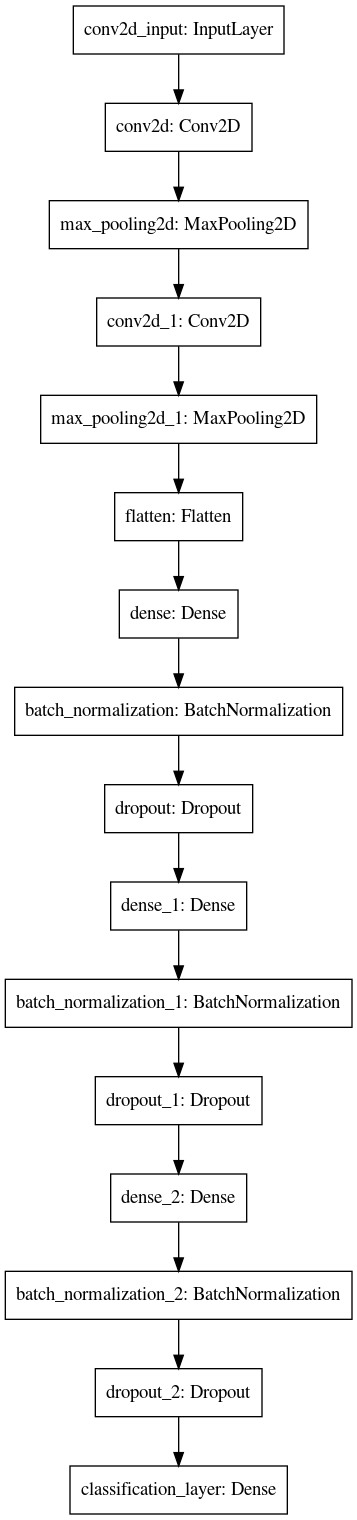

In [19]:
from keras.utils import plot_model
plot_model(Final_Model, to_file='model.png', rankdir = 'LR')